In [379]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
from tqdm import trange
import pickle


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [38]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 200)
        self.fc2 = nn.Linear(self.fc1.out_features, 400)
        self.out = nn.Linear(self.fc2.out_features, g_output_dim)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.initialize_weights()
    
    def initialize_weights(self):
        for layer in [self.fc1, self.fc2, self.out]:
            nn.init.kaiming_normal_(layer.weight)        
    
    def forward(self, x): 
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.tanh(self.out(x))

In [39]:
class Discriminator(nn.Module):
    def __init__(self, d_input_dim, p_dropout = 0.2):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 400)
        self.fc2 = nn.Linear(self.fc1.out_features, 200)
        self.fc3 = nn.Linear(self.fc2.out_features, 100)
        self.out = nn.Linear(self.fc3.out_features, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p_dropout)
        self.initialize_weights()

        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)

    
    def initialize_weights(self):
        for layer in [self.fc1, self.fc2, self.fc3, self.out]:
            nn.init.kaiming_normal_(layer.weight)        
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.relu(self.fc3(x))
        return self.sigmoid(self.out(x))

In [40]:
generator = Generator(g_input_dim = 110, g_output_dim = 784).to(device)
discriminator = Discriminator(d_input_dim = 794).to(device)

criterion = nn.BCELoss()

g_optimizer = torch.optim.AdamW(generator.parameters(), lr = 2e-4) 
d_optimizer = torch.optim.AdamW(discriminator.parameters(), lr = 2e-4) 

ndim = 100

In [392]:
mnist_train=torchvision.datasets.MNIST('mnist',
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
    ]))

In [393]:
class CGAN_Dataset(torch.utils.data.Dataset):
    def __init__(self, data, labels, transform = None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx].numpy(), self.labels[idx].float()
        if self.transform:
            image = self.transform(image)
        center = image[:, 10:20, 10:20]
        return image, center, label

In [394]:
BATCH_SIZE = 100
train_dataset = CGAN_Dataset(mnist_train.data, mnist_train.targets, transform=mnist_train.transform)
trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=3)


torch.Size([1, 28, 28]) torch.Size([1, 10, 10]) tensor(0.) tensor(-1.) tensor(1.)


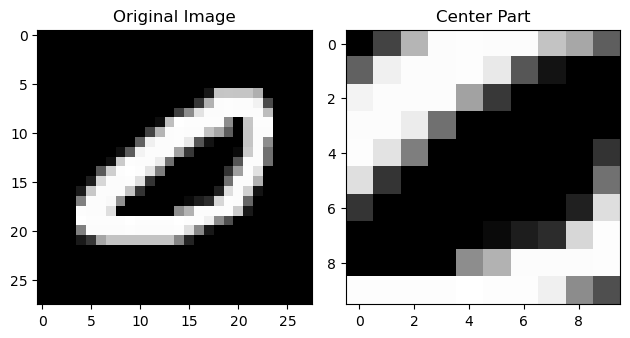

In [397]:
for i, (images, centers, labels) in enumerate(trainloader):
    print(images[0].shape, centers[0].shape, labels[0], torch.min(centers[0]), torch.max(centers[0]))
    # Plot the original image
    plt.subplot(1, 2, 1)
    plt.imshow(images[0][0], cmap='gray')
    plt.title('Original Image')

    # Plot the center part of the image
    plt.subplot(1, 2, 2)
    plt.imshow(centers[0][0], cmap='gray')
    plt.title('Center Part')
    plt.tight_layout()

    # Show the plot 
    plt.show()
    break

In [398]:
# using similar architecture as problem 3
generator = Generator(g_input_dim = 200, g_output_dim = 784).to(device)
discriminator = Discriminator(d_input_dim = 884).to(device)

criterion = nn.BCELoss()

g_optimizer = torch.optim.AdamW(generator.parameters(), lr = 2e-4) 
d_optimizer = torch.optim.AdamW(discriminator.parameters(), lr = 2e-4) 

ndim = 100

In [399]:
def gen_loss(output, real_label, fake_images, centers, lmbda = 10):
    bce_loss = nn.functional.binary_cross_entropy(output, real_label)
    mse_loss = nn.functional.mse_loss(fake_images, centers)
    return bce_loss + lmbda * mse_loss

def get_noise(batch_size, ndim):
    noise = torch.randn(batch_size, ndim).to(device)
    return noise

def get_center(images):
    images = images.view(-1, 28, 28)[:,10:20,10:20]
    return torch.flatten(images, 1)

In [400]:
epochs = 300
discriminator_loss_per_epoch, generator_loss_per_epoch, real_accuracy_per_epoch, fake_accuracy_per_epoch = [], [], [], []

real_label = torch.ones(BATCH_SIZE, 1).to(device)
fake_label = torch.zeros(BATCH_SIZE, 1).to(device)

pbar = trange(epochs, unit="epoch")

for epoch in pbar:
    total_d_loss, total_g_loss, real_accuracy, fake_accuracy= 0, 0, 0, 0
    
    for i, (images, centers, _) in enumerate(trainloader):

        images, centers = torch.flatten(images, 1).to(device), torch.flatten(centers, 1).to(device)
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # real
        real_ = torch.cat((images, centers), dim=1)

        output = discriminator(real_)
        real_loss = criterion(output, real_label)
        D_x = output.mean().item()

        # fake
        noise = torch.randn(BATCH_SIZE, ndim).to(device)
        noise = torch.cat((noise, centers), dim=1)
        fake_images = generator(noise)
        fake_ = torch.cat((fake_images, centers), dim=1).to(device)
        output = discriminator(fake_.detach())
        fake_loss = criterion(output, fake_label)

        d_loss = real_loss + fake_loss
        
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        # fake
        output = discriminator(fake_)
        g_loss = gen_loss(output, real_label, get_center(fake_images), centers)
        D_G_z2 = output.mean().item()
        
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        ############################
        # (3) Store the losses and probabilities
        ###########################
        total_d_loss += d_loss.item()
        total_g_loss += g_loss.item()
        real_accuracy += D_x
        fake_accuracy += D_G_z2
        
    total_d_loss, total_g_loss = total_d_loss / len(trainloader), total_g_loss / len(trainloader)
    discriminator_loss_per_epoch.append(total_d_loss)
    generator_loss_per_epoch.append(total_g_loss)

    real_accuracy, fake_accuracy = real_accuracy / len(trainloader), fake_accuracy / len(trainloader)
    real_accuracy_per_epoch.append(real_accuracy)
    fake_accuracy_per_epoch.append(fake_accuracy)
    
    pbar.set_description(f"Real Accuracy: {real_accuracy:.4f} Fake Accuracy: {fake_accuracy:.4f} Discriminator Loss: {total_d_loss:.4f} Generator Loss: {total_g_loss:.5f}")


Real Accuracy: 0.5625 Fake Accuracy: 0.4364 Discriminator Loss: 1.2511 Generator Loss: 0.98187: 100%|██████████| 300/300 [46:23<00:00,  9.28s/epoch]


In [401]:
torch.save(generator.state_dict(), 'best_generator_p4_model.pth')
torch.save(discriminator.state_dict(), 'best_discriminator_p4_model.pth')

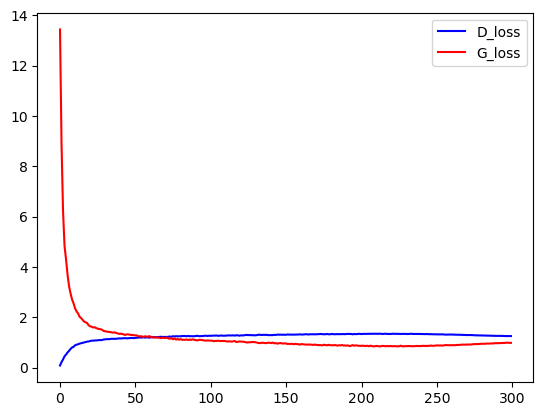

In [402]:
plt.plot(discriminator_loss_per_epoch, label='D_loss', color = 'blue')
plt.plot(generator_loss_per_epoch, label='G_loss', color = 'red')
plt.legend()
plt.show()

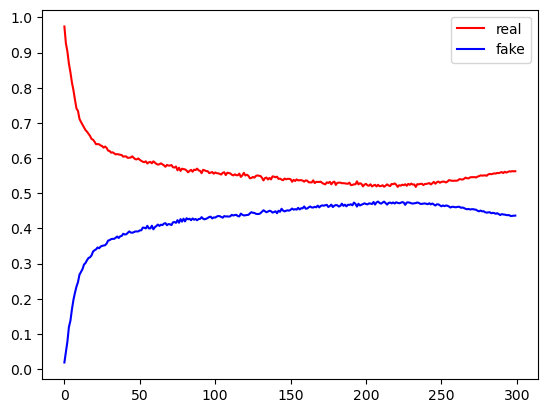

In [403]:
plt.plot(real_accuracy_per_epoch, label='real', color = 'red')
plt.plot(fake_accuracy_per_epoch, label='fake', color = 'blue')
plt.yticks(np.arange(0.0, 1.1, 0.1))
plt.legend()
plt.show()

### generate images

In [407]:
data_iter = iter(trainloader)
images, centers, labels = next(data_iter)

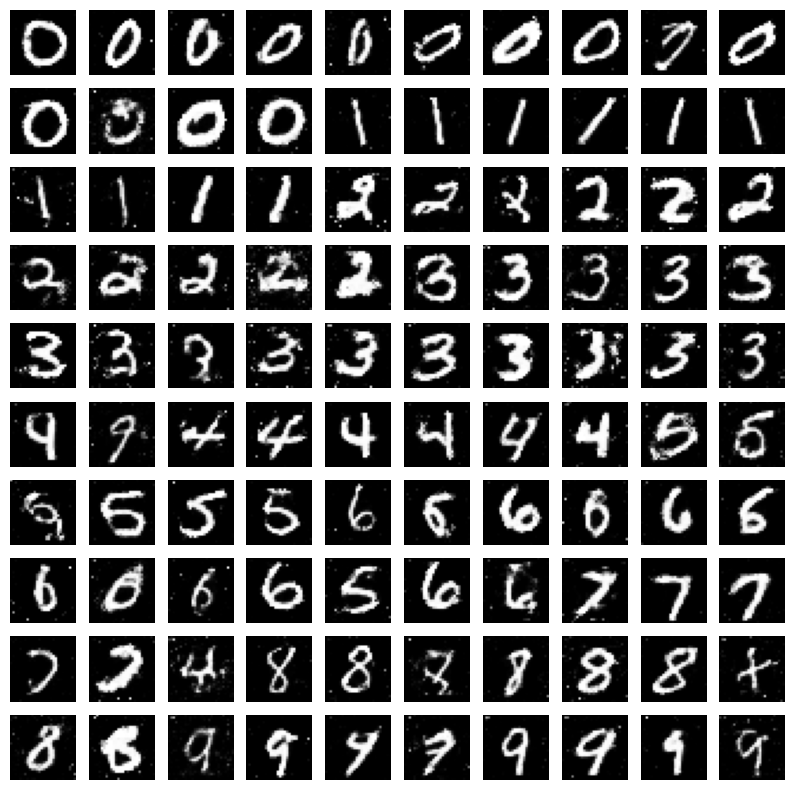

In [408]:
# Generate fake images
noise, centers = torch.randn(BATCH_SIZE, ndim).to(device), torch.flatten(centers, 1).to(device)
noise = torch.cat((noise, centers), dim=1)
with torch.no_grad():
    fake_images = generator(noise)

# Sort indices based on labels
sorted_indices = torch.argsort(labels)

# Sort fake_images and labels accordingly
fake_images_sorted = fake_images[sorted_indices]
labels_sorted = labels[sorted_indices]

# Visualize sorted fake images
outputs_sorted = fake_images_sorted.view(-1, 28, 28)
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
    for j in range(10):
        index = i * 10 + j
        out_img = outputs_sorted[index].cpu().numpy()
        axes[i, j].imshow(out_img, cmap='gray')
        axes[i, j].axis('off')
plt.show()

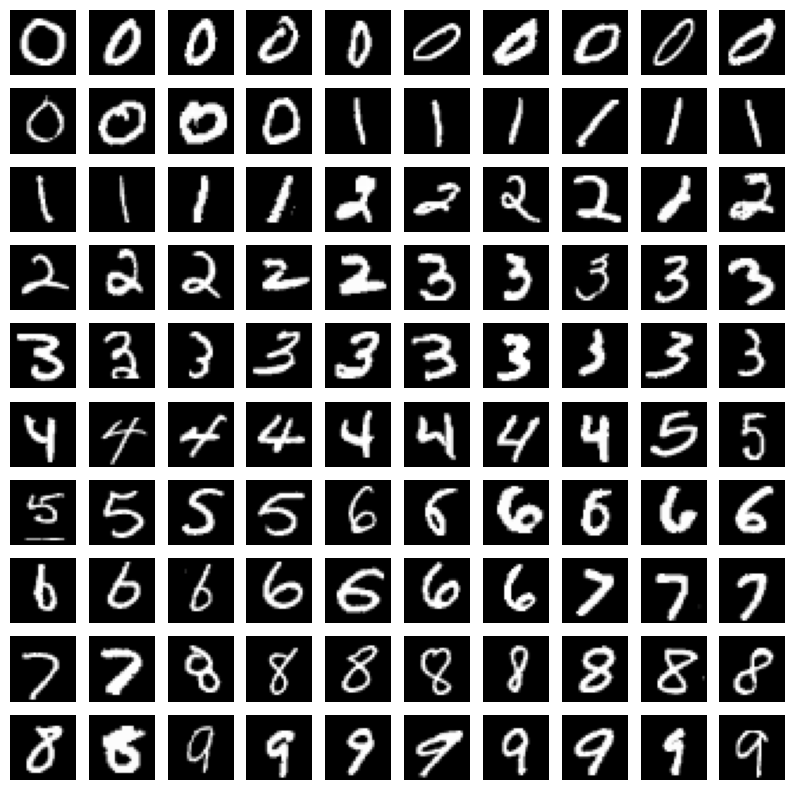

In [410]:
# original
images = images.squeeze(dim=1)
fig, axes = plt.subplots(10, 10, figsize=(10, 10))

# Sort indices based on labels
sorted_indices = torch.argsort(labels)

# Sort images and labels accordingly
images_sorted = images[sorted_indices]

for i in range(10):
    for j in range(10):
        index = i * 10 + j
        out_img = images_sorted[index].cpu().numpy()
        axes[i, j].imshow(out_img, cmap='gray')
        axes[i, j].axis('off')

plt.show()